<a href="https://colab.research.google.com/github/JR-1991/sysbiojax/blob/master/TestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from sysbiojax import Model
except ImportError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/JR-1991/sysbiojax.git

    from sysbiojax import Model

In [2]:
import jax.numpy as jnp
from jax import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

### Simple Michaelis-Menten model

In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1, s2")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")
model.add_ode("s2", "(v_max * s1) / ( K_m + s1)")

# Add parameter values
model.parameters.v_max.value = 5.0
model.parameters.K_m.value = 100.0

model

Eq(x, Matrix([[s1, s2]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

Eq(Derivative(s2, t), s1*v_max/(K_m + s1))

In [4]:
model.parameters

,Name,Value
0,K_m,100.0
1,v_max,5.0


In [5]:
initial_condition = {"s1": 100.0, "s2": 0.0}
time, states = model.simulate(
    initial_conditions=initial_condition,
    t0=0, t1=100, dt0=1, nsteps=100, in_axes=None
)

In [6]:
from tqdm import tqdm

y0 = jnp.array([100.0, 0.0])
parameters = jnp.array([5.0, 100.0])
time = jnp.linspace(0, 100, 100)

for _ in tqdm(range(100000)):
    model._sim_func(y0, parameters, time)

100%|██████████| 100000/100000 [00:02<00:00, 40905.78it/s]


In [7]:
# Run A LOT of initial conditions
initial_conditions = [
    {"s1": float(init), "s2": 0.0}
    for init in jnp.linspace(20.0, 300.0, 1_000_000)
]

In [8]:
%%time
time, states = model.simulate(
    initial_conditions=initial_conditions,
    t0=0, t1=100, dt0=1, nsteps=100, in_axes=(0, None, None)
)

CPU times: user 12.5 s, sys: 1.06 s, total: 13.6 s
Wall time: 6.57 s


In [9]:
# Run a couple for plotting
initial_conditions = [
    {"s1": 10.0, "s2": 0.0},
    {"s1": 50.0, "s2": 0.0},
    {"s1": 100.0, "s2": 0.0},
    {"s1": 150.0, "s2": 0.0},
    {"s1": 200.0, "s2": 0.0},
]

time, states = model.simulate(
    initial_conditions=initial_conditions,
    t0=0, t1=100, dt0=0.01, nsteps=100
)

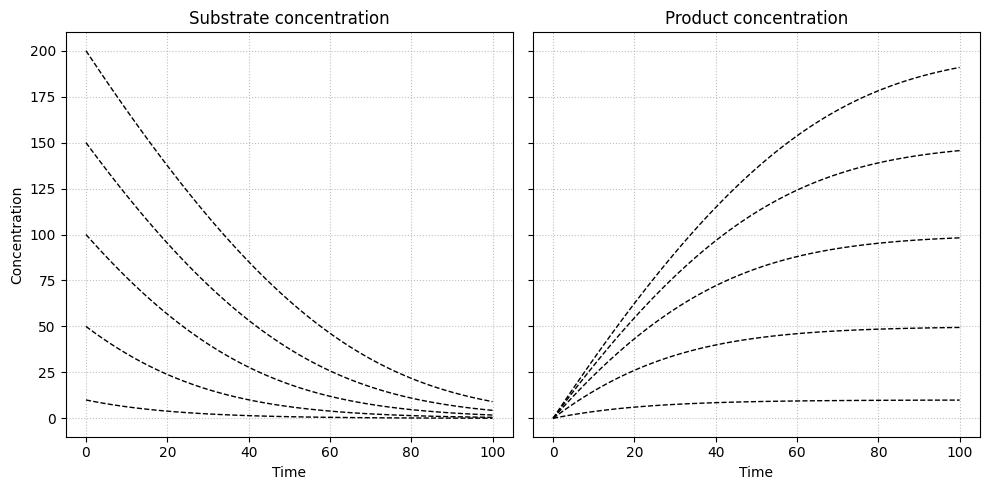

In [10]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey="row", sharex=True)
_ = ax[0].plot(time.T, states[:, :, 0].T, c="k", linewidth=1, linestyle="--")
_ = ax[1].plot(time.T, states[:, :, 1].T, c="k", linewidth=1, linestyle="--")

# Plot grids
ax[0].grid(alpha=0.8, linestyle=":")
ax[1].grid(alpha=0.8, linestyle=":")

# Axis labels
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Concentration")

# Plot title
ax[0].set_title("Substrate concentration")
ax[1].set_title("Product concentration")

plt.tight_layout()

In [11]:
# Sysbiojax also supports vmapping over parameters (Use with GPU - For CPU reduce to 10.000)
import numpy as np

# Currently parameters need to be passed as an array
# For this investigate the desired order of the parameters
print("Parameter order", model._get_parameters(None)[0])

initial_conditions = [{"s1": 100.0, "s2": 0.0}]
parameters = jnp.array([
    [float(np.random.randint(50, 300)), float(np.random.randint(2,10))]
    for _ in range(10_000)
])

print("Parameter input shape", parameters.shape)

Parameter order ['K_m', 'v_max']
Parameter input shape (10000, 2)


In [12]:
%%time
times, data = model.simulate(
    t0=0, t1=100, dt0=1.0, nsteps=100,
    initial_conditions=initial_conditions,
    parameters=parameters,
    in_axes=(None, 0, None)
)

print("Time shape", times.shape)
print("Data shape", data.shape)

Time shape (10000, 100)
Data shape (10000, 100, 2)
CPU times: user 1.23 s, sys: 21.4 ms, total: 1.25 s
Wall time: 1.22 s


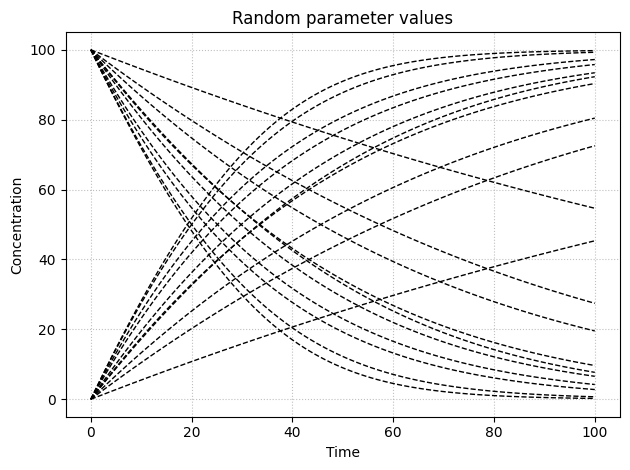

In [13]:
for batch in range(0,10):
    plt.plot(times[batch], data[batch, :, 0], c="k", linewidth=1, linestyle="--")
    plt.plot(times[batch], data[batch, :, 1], c="k", linewidth=1, linestyle="--")
    
plt.title("Random parameter values")
plt.grid(alpha=0.8, linestyle=":")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.tight_layout()

In [14]:
# You can also get the jacobian with respect to the parameters
# for sensitivity analysis or parameter estimation

# ATTENTION - The jacobian will be evaluated for a single parameter set

jac_param = model.jacobian_parameters(
    y=jnp.array([100.0, 0.0]), parameters=jnp.array([100.0, 1.0])
)

jac_param

Array([[ 0.0025, -0.5   ],
       [-0.0025,  0.5   ]], dtype=float64)

## Next steps

* ✅ Integrate `diffrax` generalized inetgration interface to simulate a given equation
  * See the following [colab notebook](https://colab.research.google.com/drive/1TRAaZe0YV7WQR127s05GcFijXJ6wPZm4?usp=sharing) for a first implementation
* ✅ Vmap for multiple initial conditions, parameters
* ✅ Global jit for `diffeqsolve`
* ✅ Jacobian with respect to parameters
* Plotting routine based on model
* Symbolic elimination
* 🚧 Add NumPyro support for Bayes analysis (Under construction)
* Add symbolic identifiability analysis (Daisy)
  * Input-Output relation by using polynomials
  * Gröbner basis for global-, local or non-identifiability
* Add Neural ODE support